# Plot CORSIKA data 

## version: 2026-01-25

thinned file from `/data/sim/IceCubeUpgrade/CosmicRay/Radio/coreas/data/continuous/star-pattern`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal, fft, constants, optimize
from functions import *

/data/user/wkammeem/CORSIKA/functions.py:193: SyntaxWarning: invalid escape sequence '\m'
  if ptype == 'muon': label = '\mu'


# parameter setting

In [2]:
#=====================================
# file paths 
#=====================================

flong = fp_long(primary, energy, sin2theta, runnum)
flist = fp_list(primary, energy, sin2theta, runnum)
finp = fp_inp(primary, energy, sin2theta, runnum)
fNmu = fp_Nmu(primary, energy, sin2theta, runnum)
fNe = fp_Ne(primary, energy, sin2theta, runnum)
fNmu_tot = fp_Nmu_tot(primary, energy, sin2theta)
fNe_tot = fp_Ne_tot(primary, energy, sin2theta)
fRadE = fp_RadE(primary, energy, sin2theta)

#=====================================
# load data
#=====================================

# antenna positions
xypos = lambda runnum: pd.read_csv(flist, sep=r"\s+",header=None)
ant_x = lambda xpos: xpos.astype(float)/1e2 # x position in m
ant_y =  lambda ypos: ypos.astype(float)/1e2 # y position in m

antx = ant_x(xypos(runnum)[2])
anty = ant_y(xypos(runnum)[3])
# muon numbers
datamu = np.loadtxt(fNmu)
mux = datamu[:,4]/1e3
muy = datamu[:,5]/1e3
w_mu = datamu[:,7]

# electron numbers
datae = np.loadtxt(fNe)
ex = datae[:,4]/1e3
ey = datae[:,5]/1e3
w_e = datae[:,7]

plt.rcParams["font.size"] = 14

with open(finp, 'r') as file:
    content = file.read()
    print(content)

RUNNR       0
EVTNR       1
SEED        41088480    0    0
SEED        42088480    0    0
SEED        43088481    0    0
NSHOW       1
ERANGE      113.07195656754287e+6    113.07195656754287e+6
ESLOPE      -1.0
PRMPAR      14
THETAP      41.7904    41.7904
PHIP        40.4008    40.4008
THIN        1e-06    113.07195656754286    0.0
THINH       2.00E+02 10.000000
ECUTS       0.02     0.01    4.0E-04 4.00E-04
CASCADE     F F F
ELMFLG      T    T
OBSLEV      284000.0
ECTMAP      1.e11
SIBYLL      T    0
SIBSIG      T
FIXHEI      0.    0
HADFLG      0    1    0    1    0    2
STEPFC      1.0
MUMULT      T
MUADDI      T
MAXPRT      1
MAGNET      16.75  -51.96
LONGI       T     10.  T    T
RADNKG      2.E5
ATMOD       33
DIRECT      /home/2134/scratch/coreas/temp/continuous/star-pattern/proton/lgE_17.0/sin2_0.4/000000/
USER        acoleman
EXIT



# longitudinal profile 

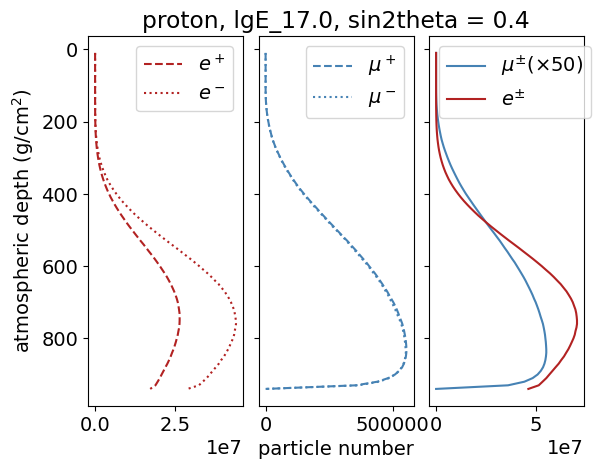

In [3]:
# load files
data = np.loadtxt(flong, skiprows=2, max_rows = 94)
atmdepth = data[:,0]

# extract data
positron = data[:,2]
electron = data[:,3]
tot_e = positron + electron

muplus = data[:,4]
muminus = data[:,5]
tot_mu = (muplus + muminus)*50

# plot
pltlp(atmdepth, positron, electron, muplus, muminus, tot_e, tot_mu)

# particle distributions

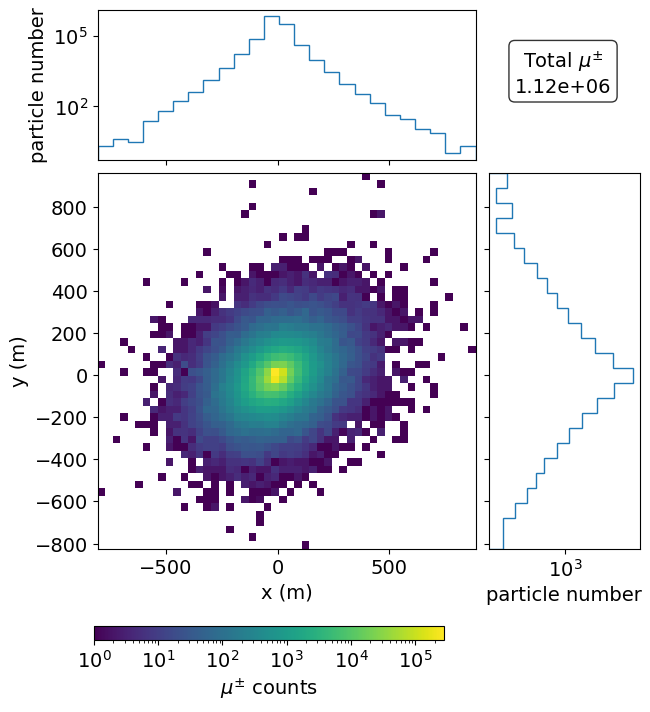

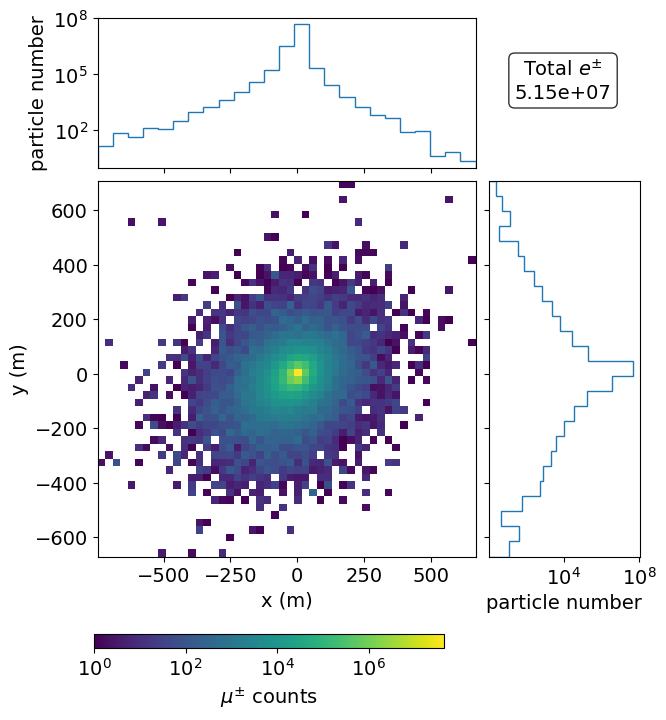

In [4]:
pltNpar(mux, muy, w_mu, 'muon')
pltNpar(ex, ey, w_e, 'electron')

# Nmu, Ne correlation

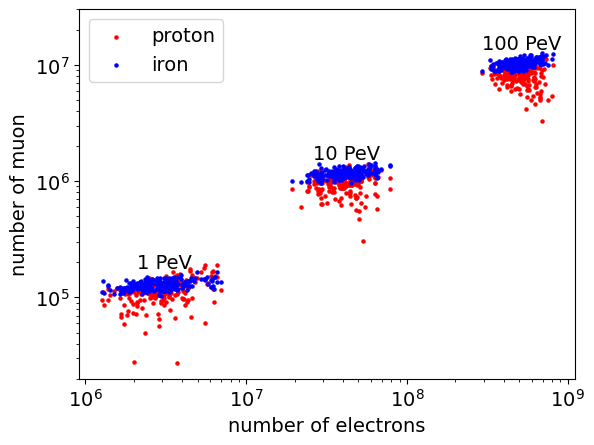

In [5]:
energies = [16.0, 17.0, 18.0] ## Energy logE 
energylabel = ["1 PeV", "10 PeV", "100 PeV"]
# sin2theta = 0.4
for i in range (len(energies)):
    energydir = f'lgE_{energies[i]}'
    
    labels = energylabel[i]
    pltmuecorr(energydir, sin2theta, labels)

# Energy radiation with bandpass filter

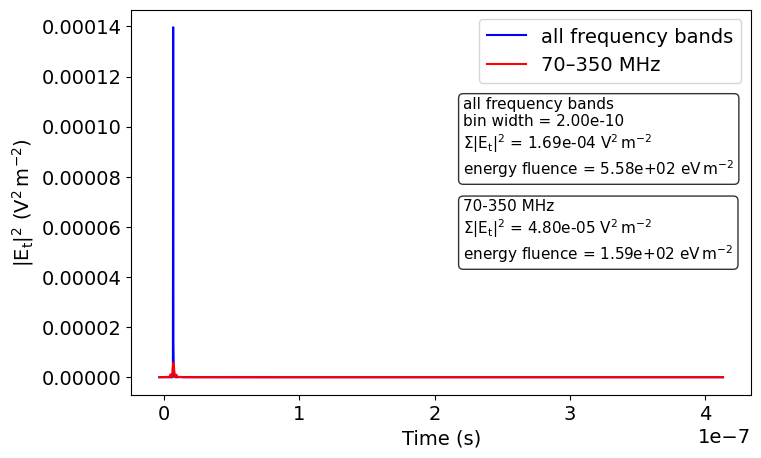

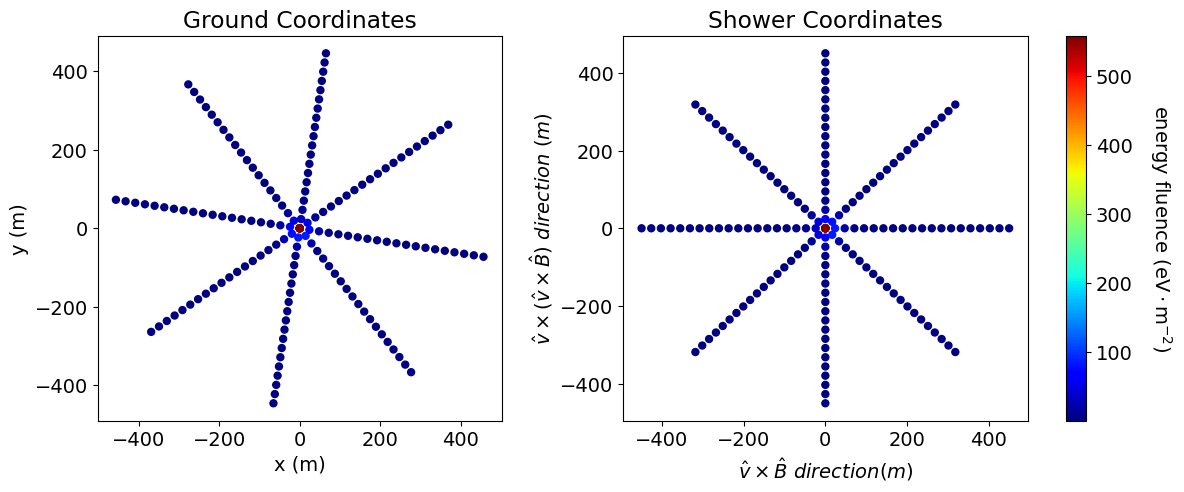

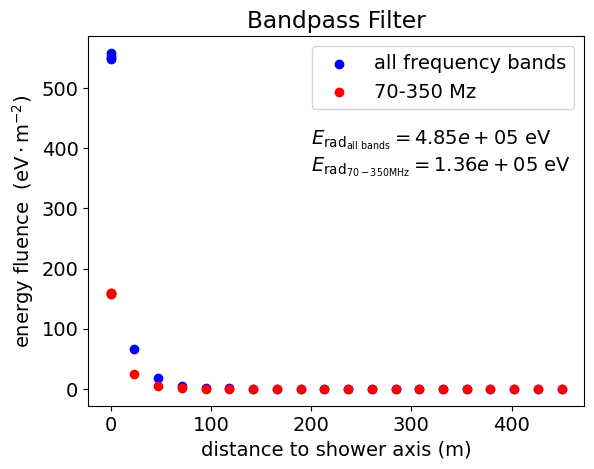

(23, 23)

In [5]:
Nant = 160 #number of total antennas
# create empty arrays of energy fluence, filtered energy fluence, vxB, and vxvxB
ef, eff, vxB, vxvxB = (np.empty(Nant) for _ in range(4))

# 160 antenna (Nant = 160) loop
for i, ant_no in enumerate(range (1,Nant+1)):
    
    radio_dat = np.loadtxt(fp_radio(primary, energy, sin2theta, runnum, ant_no))

    # extract data
    time = radio_dat[:,0]
    E_SI = 29979 # electric field converter from cgs unit to SI unit 1 statV/cm≈29,979 V/m
    Ex, Ey, Ez = radio_dat[:,1]*E_SI, radio_dat[:,2]*E_SI, radio_dat[:,3]*E_SI # north, west, vertical electric field in V/m

    #filter electric field using signal.butter
    b, a = signal.butter(5, [70e6, 350e6] , 'bp', fs=5e9)
    Ex_f, Ey_f, Ez_f = (signal.filtfilt(b, a, i) for i in (Ex, Ey, Ez))

    # |E|^2 raw and filtered
    Emag2, Emag2_f = magE2(Ex, Ey, Ez), magE2(Ex_f, Ey_f, Ez_f) 

    # sum(|E|^2)
    E_sum, E_sum_f = sum(Emag2), sum(Emag2_f)
     
    # energy fluence 
    ef[i], eff[i] = energyfluence(E_sum), energyfluence(E_sum_f)

    # plot |E|^2 histogram for antenna number 1 
    if ant_no == 1:
        pltEmag2(time, time, Emag2, Emag2_f, E_sum, E_sum_f, 'plot')
# plot energy fluence map choose weather colors = ef or colors = eff
pltefmap(finp, Nant, vxB, vxvxB, antx, anty, ef)
# plot radius vs energy fluence
pltef(vxB, vxvxB, ef, eff, 'bp')

# Energy radiation with FFT

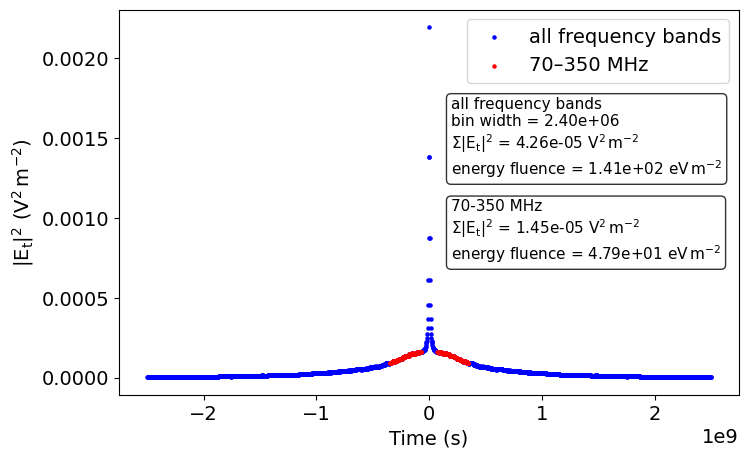

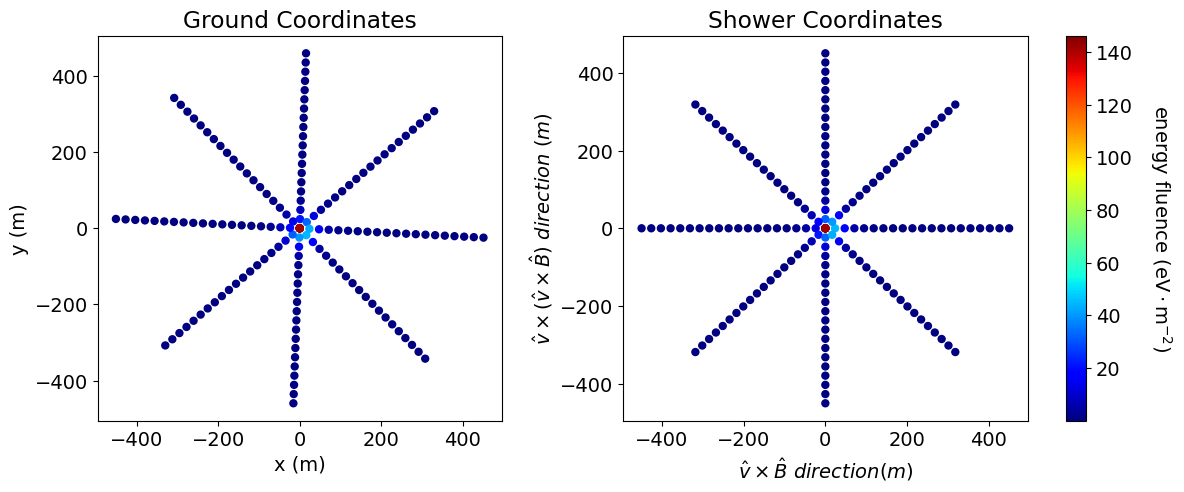

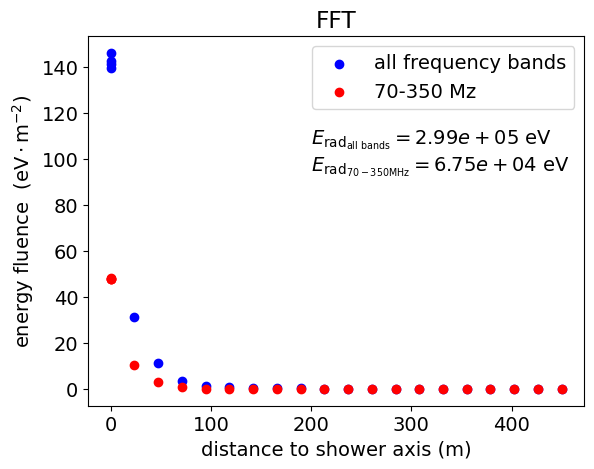

(23, 23)

In [7]:
Nant = 160 #number of total antennas
# create empty arrays of energy fluence, filtered energy fluence, vxB, and vxvxB
ef, eff, vxB, vxvxB = (np.empty(Nant) for _ in range(4))

fmin,fmax = 70e6, 350e6 # frequency range 70-350 MHz

# 160 antenna (Nant = 160) loop
for i, ant_no in enumerate(range (1,Nant+1)):
    
    radio_dat = np.loadtxt(fp_radio(primary, energy, sin2theta, runnum, ant_no))

    # extract data
    time = radio_dat[:,0]
    E_SI = 29979 # electric field converter from cgs unit to SI unit 1 statV/cm≈29,979 V/m
    Ex, Ey, Ez = radio_dat[:,1]*E_SI, radio_dat[:,2]*E_SI, radio_dat[:,3]*E_SI # north, west, vertical electric field in V/m
    Er = np.sqrt(Ex**2 + Ey**2 + Ez**2) 

    # FFT
    dt = time[1] - time[0]
    N  = len(time)
    Efft = fft.fft(Er) # real valued signal, use rfft
    freq = (np.fft.fftfreq(N, dt))

    Efft2 = abs(Efft)**2
    E_sum = fftsum(N, Efft2)

    # restrict energy range
    mask = (abs(freq) >= fmin) & (abs(freq) <= fmax)
    Efft2_mask = abs(Efft[mask])**2
    freq_f = freq[mask]
    E_sum_f = fftsum(N, Efft2_mask)

    # energy fluence 
    ef[i], eff[i] = energyfluence(E_sum), energyfluence(E_sum_f)

    # plot |E|^2 histogram for antenna number 1 
    if ant_no == 1:
        pltEmag2(freq, freq_f, Efft2, Efft2_mask, E_sum, E_sum_f, 'scatter')

# plot energy fluence map choose weather colors = ef or colors = eff
pltefmap(finp, Nant, vxB, vxvxB, antx, anty, ef)

# plot radius vs energy fluence
pltef(vxB, vxvxB, ef, eff, 'fft')

# Ne vs. Radiation Energy

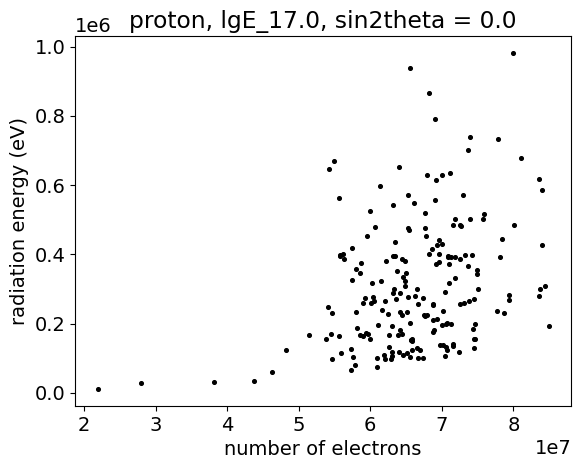

In [3]:
fNe_tot = fp_Ne_tot(primary, energy, sin2theta)
fRadE = fp_RadE(primary, energy, sin2theta)
fileNe = np.loadtxt(fNe_tot)
Ne = fileNe[:,5]
fileRadE = np.loadtxt(fRadE)
RadE = fileRadE[:,1]

plt.scatter(Ne, RadE, s = 7, color = 'black')
plt.xlabel('number of electrons')
plt.ylabel('radiation energy (eV)')
plt.title(f'{primary}, {energy}, sin2theta = {sin2theta}')
plt.ticklabel_format(axis='x', style='sci', scilimits=(0, 0)) 